<a href="https://colab.research.google.com/github/mukesh527/SST-Prediction/blob/main/Sales_prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Sales Prediction Model File**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 6.6MB/s 
     |████████████████████████████████| 6.5MB 17.6MB/s 
     |████████████████████████████████| 15.3MB 55.2MB/s 


**Reading input data**

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point,Polygon,LineString
import matplotlib.pyplot as plt

# Reading & Analysing Data

Function to Reduce Dataframe memory

In [ ]:
#***** Function to reduce dataframe memory**************************************#

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

#*******************************************************************************************************

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Final_Hack/train.csv',low_memory=False)


In [ ]:
train['unit_sales']=train['unit_sales'].apply(abs)


In [ ]:
train['unit_sales'].sort_values(ascending=True)

80289872        0.001
98296018        0.002
92763061        0.003
41930965        0.003
76352112        0.003
              ...    
77959454    20000.000
76693277    20748.000
77960441    30000.000
76939364    44142.000
93189596    89440.000
Name: unit_sales, Length: 101688779, dtype: float64

In [ ]:
Q1=(train['unit_sales'].sort_values(ascending=True)).quantile(0.25)
Q3=(train['unit_sales'].sort_values(ascending=True)).quantile(0.75)
IQR=(Q3-Q1)


In [ ]:
train_1=train.loc[train['unit_sales']>(Q1-1.5*IQR)]


In [ ]:
train=train_1.loc[train_1['unit_sales']<(Q3+1.5*IQR)]
train.shape

(92166284, 5)

In [ ]:
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 4219.037658691406  MB
******************************
Column:  unit_sales
dtype before:  float64
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  3867.451187133789  MB
This is  91.66666666666667 % of the initial size
_________________

_________________

[]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Row(date=None, locationId=None, item_id=None, unit_sales=None, onpromotion=None)

In [ ]:
train.to_csv('/content/drive/MyDrive/Final_Hack/train_without_Outlier.csv')



In [ ]:
train.head()

,date,locationId,item_id,unit_sales,onpromotion
0,2015-01-01,location_25,item_103665,7.0,NaN
1,2015-01-01,location_25,item_105574,1.0,NaN
2,2015-01-01,location_25,item_105575,2.0,NaN
3,2015-01-01,location_25,item_108079,1.0,NaN
4,2015-01-01,location_25,item_108701,1.0,NaN


In [ ]:
#train['date'] =  pd.to_datetime(train['date'], format='%Y-%m-%d')
train['locationId']=train['locationId'].astype('category')
train['item_id']=train['item_id'].astype('category')
train['onpromotion']=train['onpromotion'].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
#train.groupby(['locationId'])['unit_sales'].sum()



location_25
location_1
location_2
location_3
location_4
location_5
location_6
location_7
location_8
location_9
location_10
location_11
location_12
location_13
location_14
location_15
location_16
location_17
location_18
location_19
location_23
location_24
location_26
location_27
location_28
location_30
location_31
location_32
location_33
location_34
location_35
location_37
location_38
location_39
location_40
location_41
location_43
location_44
location_45
location_46
location_47
location_48
location_49
location_50
location_51
location_54
location_36
location_53
location_20
location_29
location_21
location_42
location_22


In [ ]:

#t+str.split(i,'_')[1]
li=[train.loc[train['locationId']==i] for i in train.locationId.unique()]
# for i in train.locationId.unique():

#   li=train.loc[train['locationId']==i]
  


In [ ]:
location.head()

,location_id,city,state,type,cluster
0,location_1,Bengaluru,Karnataka,D,13
1,location_2,Bengaluru,Karnataka,D,13
2,location_3,Bengaluru,Karnataka,D,8
3,location_4,Bengaluru,Karnataka,D,9
4,location_5,Delhi,NCR,D,4


In [ ]:
location=pd.read_csv('/content/drive/MyDrive/Final_Hack/location_details.csv')
item_id=pd.read_csv('/content/drive/MyDrive/Final_Hack/item_details.csv')
transaction_train=pd.read_csv('/content/drive/MyDrive/Final_Hack/train_transactions.csv')

In [ ]:
pd.merge(train,location,how='left',left_on='locationId',right_on='location_id')

In [ ]:
item_id.head()

,item_id,category_of_item,class,perishable
0,item_96995,grocery_items,class_1093,0
1,item_99197,grocery_items,class_1067,0
2,item_103501,cleaning_utilities,class_3008,0
3,item_103520,grocery_items,class_1028,0
4,item_103665,baked_items / bread_based,class_2712,1


In [ ]:
transaction_train.head()

,date,location_identifier,transactions
0,2015-01-01,location_25,770
1,2015-01-02,location_1,2111
2,2015-01-02,location_2,2358
3,2015-01-02,location_3,3487
4,2015-01-02,location_4,1922


**Task 1 : Aggregate/Merge all data to train dataframe**

In [ ]:
# train_chunk1=pd.merge(t1,location,how='left',left_on='locationId',right_on='location_id').drop(['location_id'],axis=1)
# train_chunk1.cluster.value_counts()
train_chunks=pd.merge(li[0],location,how='left',left_on='locationId',right_on='location_id').drop(['location_id'],axis=1)

# Using BigData

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf /content/spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("Spark ML Application")\
        .master('local[*]')\
        .getOrCreate()

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [ ]:
TrainDataSchema = StructType([
    StructField("date", TimestampType(), True),
    StructField("locationId", StringType(), True),
    StructField("item_id", StringType(), True),
    StructField("unit_sales", DoubleType(), True),
    StructField("onpromotion", BooleanType(), True),])

In [ ]:
train_sparkdf = spark.read.csv(path='/content/drive/MyDrive/Final_Hack/train_without_Outlier.csv',header=True)


#106565000


In [ ]:
location=spark.read.csv(path='/content/drive/MyDrive/Final_Hack/location_details.csv',header=True,inferSchema=True)
item_id=spark.read.csv(path='/content/drive/MyDrive/Final_Hack/item_details.csv',header=True,inferSchema=True)
transactions=spark.read.csv(path='/content/drive/MyDrive/Final_Hack/train_transactions.csv',header=True,inferSchema=True)

In [ ]:
train_sparkdf.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- date: string (nullable = true)
 |-- locationId: string (nullable = true)
 |-- item_id: string (nullable = true)
 |-- unit_sales: string (nullable = true)
 |-- onpromotion: string (nullable = true)



In [ ]:
#train.select(min("unit_sales"), max("unit_sales")).show()
train_sparkdf.show()

+---+----------+-----------+-----------+----------+-----------+
|_c0|      date| locationId|    item_id|unit_sales|onpromotion|
+---+----------+-----------+-----------+----------+-----------+
|  0|2015-01-01|location_25|item_103665|       7.0|       null|
|  1|2015-01-01|location_25|item_105574|       1.0|       null|
|  2|2015-01-01|location_25|item_105575|       2.0|       null|
|  3|2015-01-01|location_25|item_108079|       1.0|       null|
|  4|2015-01-01|location_25|item_108701|       1.0|       null|
|  5|2015-01-01|location_25|item_108786|       3.0|       null|
|  6|2015-01-01|location_25|item_108797|       1.0|       null|
|  7|2015-01-01|location_25|item_108952|       1.0|       null|
|  8|2015-01-01|location_25|item_111397|      13.0|       null|
|  9|2015-01-01|location_25|item_114790|       3.0|       null|
| 10|2015-01-01|location_25|item_114800|       1.0|       null|
| 11|2015-01-01|location_25|item_115267|       1.0|       null|
| 12|2015-01-01|location_25|item_115611|

In [ ]:
train_sparkdf.filter(train.unit_sales<0).show()

TypeError: ignored

In [ ]:
import pyspark.sql.functions as func
train.filter(func.col('unit_sales')<=0).count()

6162

In [ ]:
train.select('unit_sales').summary().show()

+-------+------------------+
|summary|        unit_sales|
+-------+------------------+
|  count|         101688779|
|   mean| 8.647889531772222|
| stddev|23.495334049010957|
|    min|          -15372.0|
|    25%|               2.0|
|    50%|               4.0|
|    75%|               9.0|
|    max|           89440.0|
+-------+------------------+



In [ ]:

train=train.withColumn('unit_sales',func.abs('unit_sales'))
train.filter(func.col('unit_sales')<=0)



SyntaxError: ignored

In [ ]:
location=location.withColumnRenamed('location_id','locationId')
#location.show(5)

In [ ]:
df1=train_sparkdf.join(other=location,on='locationId',how='left')

In [ ]:
#df1.show(5)

In [ ]:
#item_id.show(5)

In [ ]:
df2=df1.join(other=item_id,on='item_id',how='left')
#df2.show(5)

In [ ]:
print(train.count())
print(df2.count())

In [ ]:
print(df1.count())

In [ ]:
#transactions.show(5)

In [ ]:
transactions=transactions.withColumnRenamed('location_identifier','locationId')
#transactions.show(5)

In [ ]:
df3=df2.join(transactions,on=['date','locationId'],how='left')

In [ ]:
df3.show(5)

+----------+-----------+-----------+---+----------+-----------+------+-------------+----+-------+--------------------+----------+----------+------------+
|      date| locationId|    item_id|_c0|unit_sales|onpromotion|  city|        state|type|cluster|    category_of_item|     class|perishable|transactions|
+----------+-----------+-----------+---+----------+-----------+------+-------------+----+-------+--------------------+----------+----------+------------+
|2015-01-01|location_25|item_103665|  0|       7.0|       null|Kanpur|Uttar Pradesh|   D|      1|baked_items / bre...|class_2712|         1|         770|
|2015-01-01|location_25|item_105574|  1|       1.0|       null|Kanpur|Uttar Pradesh|   D|      1|       grocery_items|class_1045|         0|         770|
|2015-01-01|location_25|item_105575|  2|       2.0|       null|Kanpur|Uttar Pradesh|   D|      1|       grocery_items|class_1045|         0|         770|
|2015-01-01|location_25|item_108079|  3|       1.0|       null|Kanpur|Uttar 

**Finding the Item that sold maximum units**



---



---





In [ ]:
item_sales=df3.groupby('item_id').sum('unit_sales').toDF('item_id','total_sales')

In [ ]:
#item_sales.describe("total_sales").filter("summary = 'max'").show()
item_sales.describe("total_sales").filter("summary = 'min'")

KeyboardInterrupt: ignored

In [ ]:
sales_Item=item_sales.toPandas()

In [ ]:
sales_Item.to_pickle('/content/drive/MyDrive/Final_Hack/Highest_Item_sales')

In [ ]:
sales_Item[sales_Item['total_sales']==sales_Item.total_sales.max()]


,item_id,total_sales
2617,item_1503844,4.845388e+06


In [ ]:
sales_Item[sales_Item['total_sales']==sales_Item.total_sales.min()]

,item_id,total_sales
767,item_1047793,3.0


**Finding Highest item sold in perishable category and non perishable category**

In [ ]:
Perishable_Items=df3.groupby('perishable','item_id').sum('unit_sales').toDF('perishable','item_id','total_sales')

In [ ]:
Perishable_Items.show()

+----------+------------+------------------+
|perishable|     item_id|       total_sales|
+----------+------------+------------------+
|         0| item_261700|          601582.0|
|         0|item_1060036|          281685.0|
|         0|item_1102268|          283301.0|
|         0| item_724498|          677475.0|
|         0|item_1012788|          168023.0|
|         1|item_1038950|          118772.0|
|         0| item_929627|          178274.0|
|         1| item_358134|          160812.0|
|         1|item_1696007| 842414.5574000002|
|         0|item_1248391|          119387.0|
|         1|item_1550461|196394.33479999998|
|         0|item_1359503|           95337.0|
|         0|item_1449645|            4003.0|
|         0|item_1913055|            4504.0|
|         0|item_1917879|           68294.0|
|         1|item_2007250|           26895.0|
|         0|item_1965457|            1273.0|
|         0|item_2012576|            9304.0|
|         0|item_2018397|           22560.0|
|         

**Subsetting only for one Item among 4000 items which was sold maximum among all**

In [ ]:
# df_item_103665=df3.where(df3('item_id')='item_103665')
#df_item_103665=df3.filter(df3.item_id == "item_103665")
df_item_1503844=df3.filter(df3.item_id == "item_1503844")
df_item_1047679=df3.filter(df3.item_id=='item_1047679')

In [ ]:
df_item_1503844.show()

+----------+-----------+------------+--------+----------+-----------+---------+-------------+----+-------+------------------+----------+----------+------------+
|      date| locationId|     item_id|     _c0|unit_sales|onpromotion|     city|        state|type|cluster|  category_of_item|     class|perishable|transactions|
+----------+-----------+------------+--------+----------+-----------+---------+-------------+----+-------+------------------+----------+----------+------------+
|2016-01-02|location_31|item_1503844|16361843|    10.892|       null|   Nagpur|  Maharashtra|   B|     10|other_farm_produce|class_2022|         1|        1471|
|2016-01-03|location_26|item_1503844|16422851|     5.985|       null|   Mumbai|  Maharashtra|   D|     10|other_farm_produce|class_2022|         1|         725|
|2016-01-04|location_26|item_1503844|16489599|     6.923|       null|   Mumbai|  Maharashtra|   D|     10|other_farm_produce|class_2022|         1|         810|
|2016-01-04|location_31|item_15038

**Converting spark Dataframe to Pandas Dataframe for faster Analysis**

In [ ]:
pdf_item_1503844=df_item_1503844.toPandas()
pdf_item_1047679=df_item_1047679.toPandas()

In [ ]:
pdf_item_1503844.shape
pdf_item_1503844.to_pickle('/content/drive/MyDrive/Final_Hack/pdf_item_1503844')
pdf_item_1047679.to_pickle('/content/drive/MyDrive/Final_Hack/pdf_item_1047679')


In [ ]:
#pdf_item_103665.to_pickle(path='/content/drive/MyDrive/Final_Hack/dataframe')

In [ ]:
# pdf_item_103665['year']=pdf_item_103665['date'].dt.year
# pdf_item_103665['month']=pdf_item_103665['date'].dt.month

In [ ]:
pdf_item_1503844['unit_sales']=pdf_item_1503844['unit_sales'].astype('float')
pdf_item_1047679['unit_sales']=pdf_item_1047679['unit_sales'].astype('float')

**Subsetting Year wise sales for Item_id = item_1503844**

In [ ]:

# pdf_item_103665=pdf_item_103665.set_index(['date'])
# pdf_item_103665.index=pd.to_datetime(pdf_item_103665.index,unit='s')
pdf_item_1503844.dtypes

date                 object
locationId           object
item_id              object
_c0                  object
unit_sales          float64
onpromotion          object
city                 object
state                object
type                 object
cluster               int32
category_of_item     object
class                object
perishable            int32
transactions        float64
dtype: object

# Visualizations &  Insights

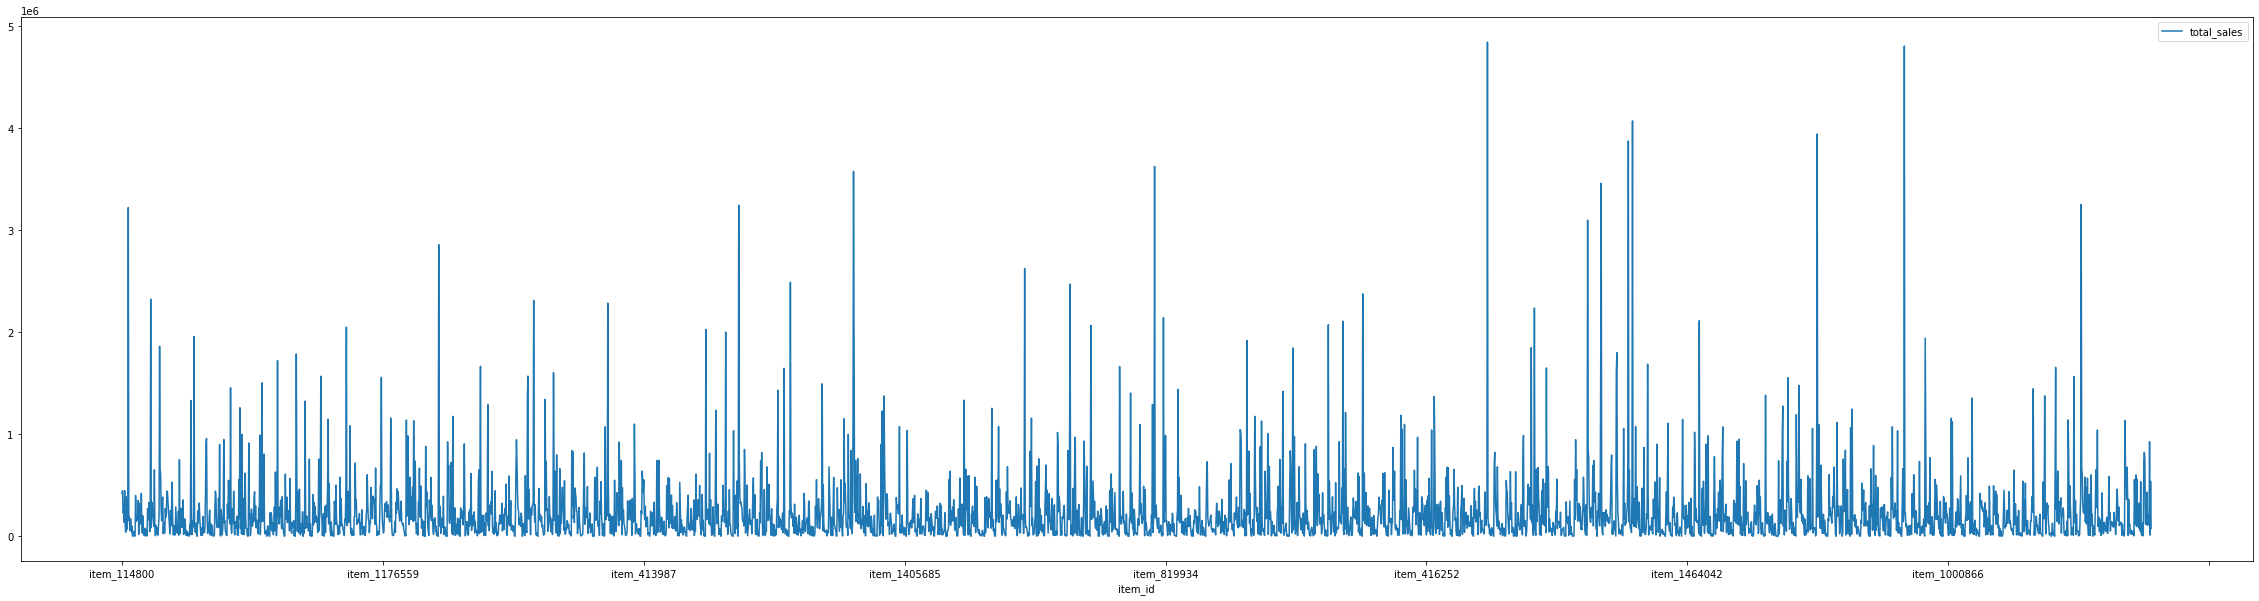

In [ ]:
#Finding Item having highest sales (Plot 1) and Items above mean sales (Plot 2)

sales_table_highest_Item=pd.read_pickle('/content/drive/MyDrive/Final_Hack/Highest_Item_sales')
sales_table_highest_Item.sort_values('total_sales',ascending=False)
sales_table_highest_Item.set_index('item_id',inplace=True)
sales_table_highest_Item.plot(figsize=(40
                                       ,10))

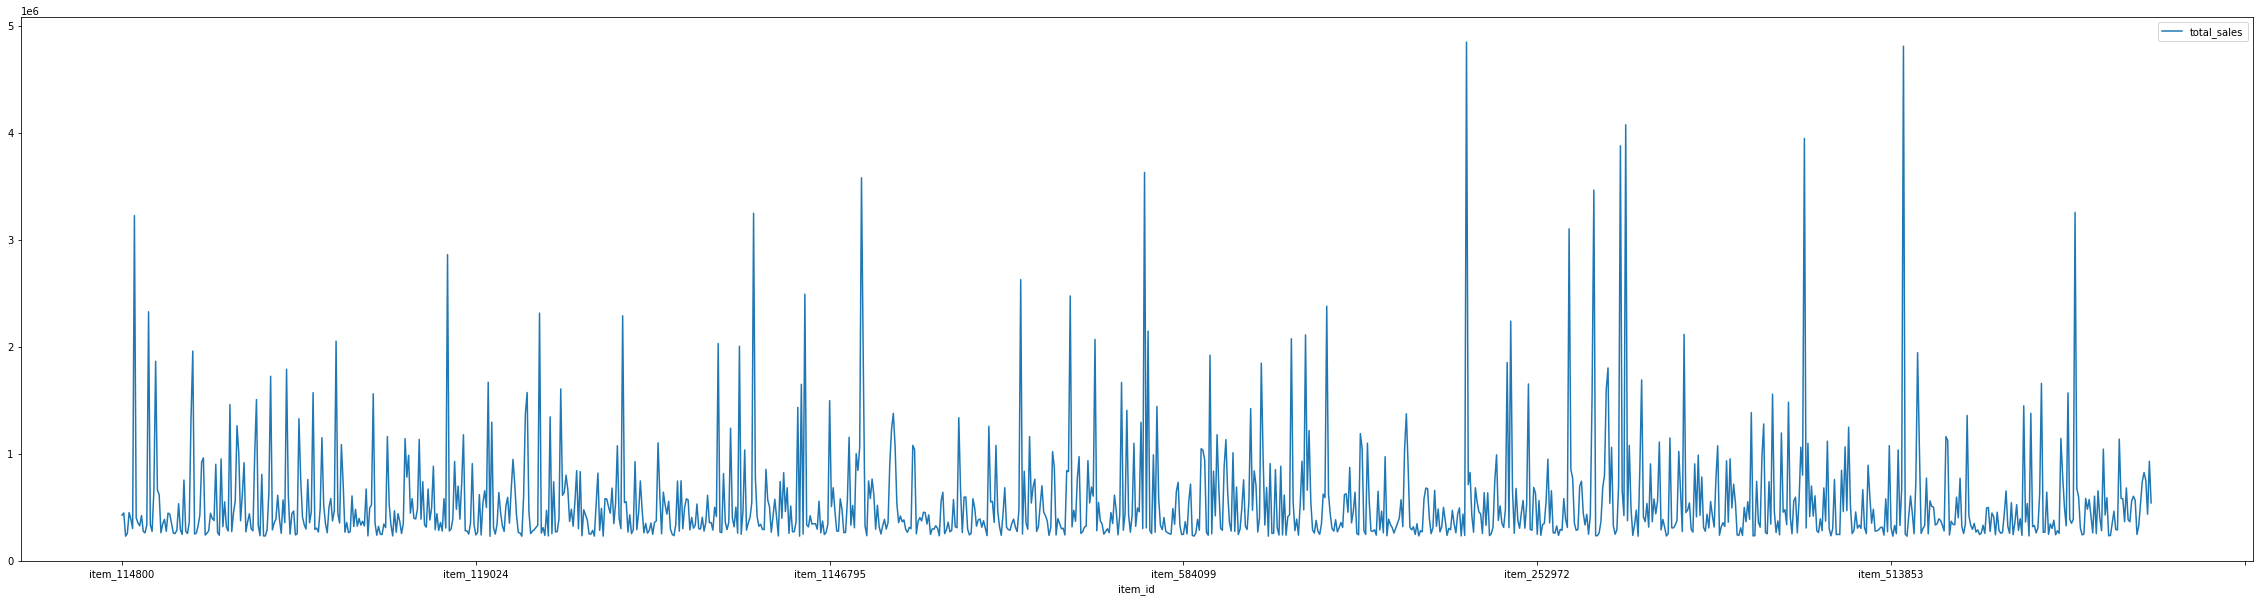

In [ ]:
sales_table_highest_Item.loc[sales_table_highest_Item['total_sales']>sales_table_highest_Item.total_sales.mean()].plot(figsize=(40,10))

In [4]:
##*****************Reading from Pickle file for faster access************
pdf_item_1503844=pd.read_pickle('/content/drive/MyDrive/Final_Hack/pdf_item_1503844')
pdf_item_1047679=pd.read_pickle('/content/drive/MyDrive/Final_Hack/pdf_item_1047679')
pdf_item_1047679.dtypes

date                 object
locationId           object
item_id              object
_c0                  object
unit_sales           object
onpromotion          object
city                 object
state                object
type                 object
cluster               int32
category_of_item     object
class                object
perishable            int32
transactions        float64
dtype: object

In [5]:
pdf_item_1503844['date']=pd.to_datetime(pdf_item_1503844['date'])
pdf_item_1047679['date']=pd.to_datetime(pdf_item_1047679['date'])
pdf_item_1503844['state']=pdf_item_1503844['state'].astype('category')
pdf_item_1047679['state']=pdf_item_1047679['state'].astype('category')
pdf_item_1503844['unit_sales']=pdf_item_1503844['unit_sales'].astype('float')
pdf_item_1047679['unit_sales']=pdf_item_1047679['unit_sales'].astype('float')
pdf_item_1503844['type']=pdf_item_1503844['type'].astype('category')
pdf_item_1047679['type']=pdf_item_1047679['type'].astype('category')
pdf_item_1503844['item_id']=pdf_item_1503844['item_id'].astype('category')
pdf_item_1047679['item_id']=pdf_item_1047679['item_id'].astype('category')
pdf_item_1503844['locationId']=pdf_item_1503844['locationId'].astype('category')
pdf_item_1047679['locationId']=pdf_item_1047679['locationId'].astype('category')

In [6]:
pdf_item_1503844['year']=pdf_item_1503844['date'].dt.year
pdf_item_1503844['month']=pdf_item_1503844['date'].dt.month

pdf_item_1047679['year']=pdf_item_1047679['date'].dt.year
pdf_item_1047679['month']=pdf_item_1047679['date'].dt.month

In [7]:

pdf_item_1503844=pdf_item_1503844.set_index(['date'])
pdf_item_1503844.index=pd.to_datetime(pdf_item_1503844.index,unit='s')

pdf_item_1047679=pdf_item_1047679.set_index(['date'])
pdf_item_1047679.index=pd.to_datetime(pdf_item_1047679.index,unit='s')


**Sales of the item_1503844 satewise**

*   Maharashtra has highest recorded sales for this item
*   Maharashtra has sales highest across the time period



In [ ]:
pdf_item_1503844.loc[pdf_item_1503844['state'] == s, 'unit_sales'].resample('D').sum()

date
2016-01-02               10.892
2016-01-03                5.985
2016-01-04           6.9234.185
2016-01-05             9.5383.6
2016-01-06    9.35416.92314.878
                    ...        
2018-12-27                    0
2018-12-28                3.351
2018-12-29                3.027
2018-12-30          17.1893.378
2018-12-31                6.595
Freq: D, Name: unit_sales, Length: 1095, dtype: object

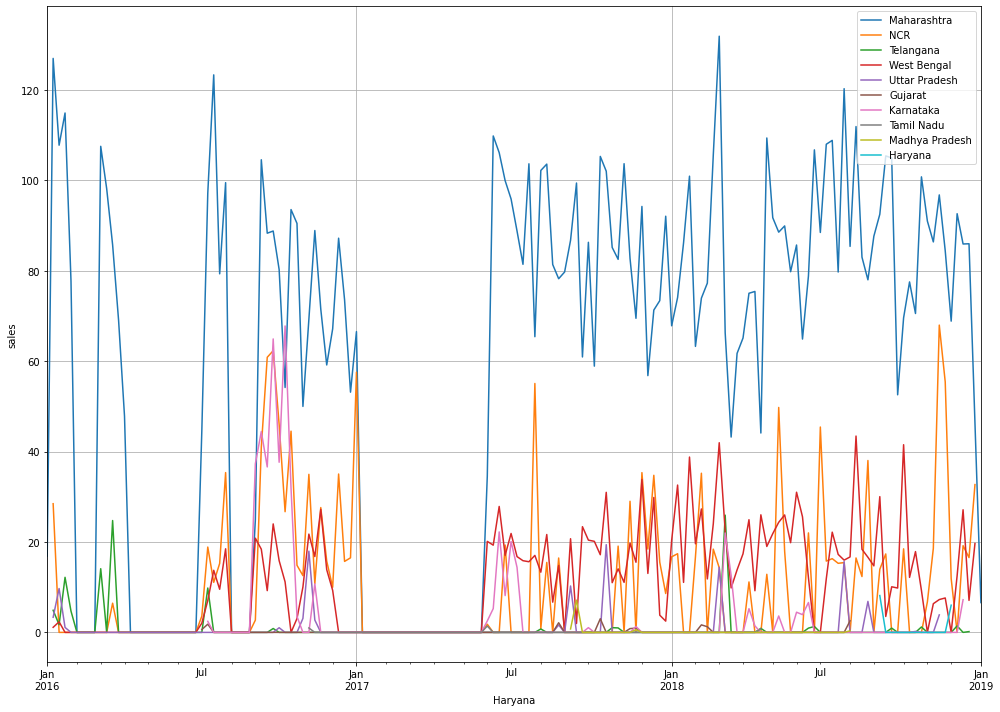

In [ ]:
num_states = len(pdf_item_1503844['state'].unique())
fig, axes = plt.subplots( figsize=(14, 10))

flag=0
for s in pdf_item_1503844['state'].unique():
 
    t = pdf_item_1503844.loc[pdf_item_1503844['state'] == s, 'unit_sales'].resample('w').sum()
    ax = t.plot(label=s) 
    ax.grid()
    ax.set_xlabel(s)
    ax.set_ylabel('sales')
    ax.legend()
    flag=flag+1
fig.tight_layout();

In [ ]:
pdf_item_1503844['cluster']=pdf_item_1503844['cluster'].astype('category')
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month
date,,,,,,,,,,,,,,,
2016-01-02,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1
2016-01-03,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1
2016-01-04,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1
2016-01-04,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1
2016-01-05,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1


**Sales of the item cluster wise**

cluster
1       13
2        4
3      108
4       75
6      363
7        4
8        1
9        3
10    1193
11       1
13       4
15      18
16      41
17       3
Name: state, dtype: int64

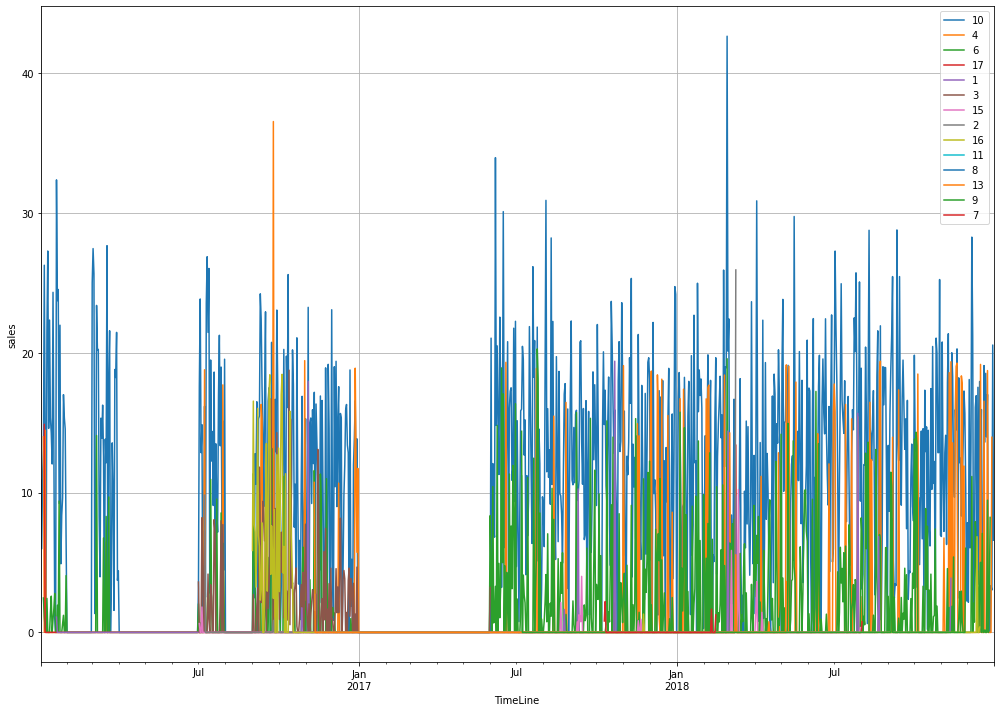

In [ ]:
num_states = len(pdf_item_1503844['cluster'].unique())
fig, axes = plt.subplots( figsize=(14, 10))

flag=0
for s in pdf_item_1503844['cluster'].unique():
 
    t = pdf_item_1503844.loc[pdf_item_1503844['cluster'] == s, 'unit_sales'].resample('D').sum()
    ax = t.plot(label=s) 
    ax.grid()
    ax.set_xlabel('TimeLine')
    ax.set_ylabel('sales')
    ax.legend()
    flag=flag+1
fig.tight_layout();

**Sales of the item citywise**

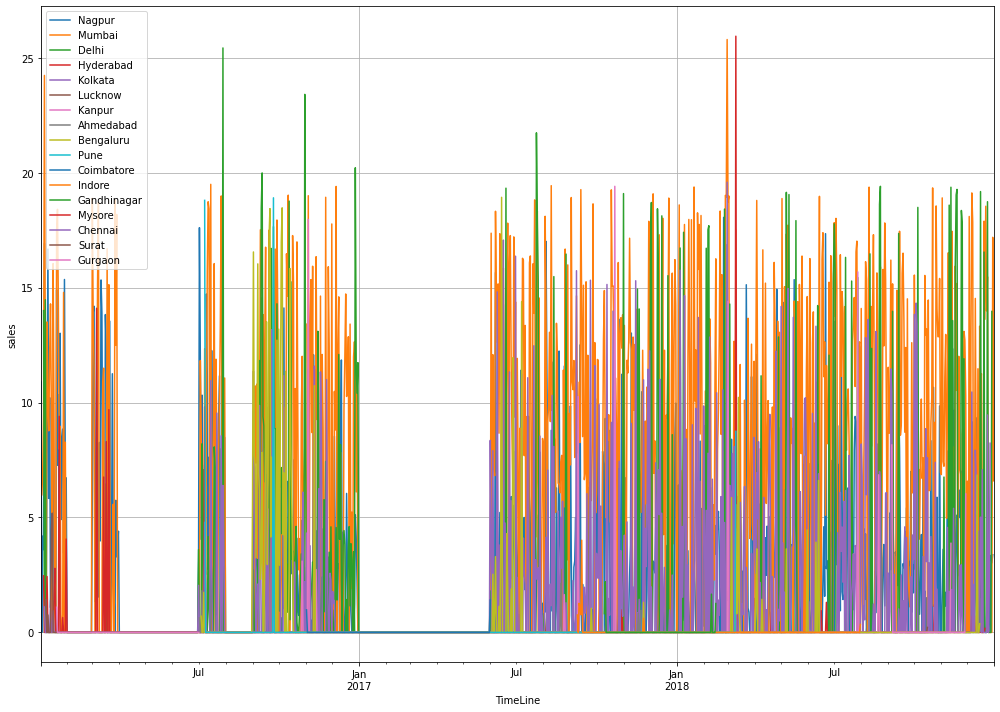

In [ ]:
num_states = len(pdf_item_1503844['city'].unique())
fig, axes = plt.subplots( figsize=(14, 10))

flag=0
for s in pdf_item_1503844['city'].unique():
 
    t = pdf_item_1503844.loc[pdf_item_1503844['city'] == s, 'unit_sales'].resample('D').sum()
    ax = t.plot(label=s) 
    ax.grid()
    ax.set_xlabel('TimeLine')
    ax.set_ylabel('sales')
    ax.legend()
    flag=flag+1
fig.tight_layout();

**Which Business unit had highest sale for form 2015 to 2019 for this Item_1503844**

*   Business unit type C has highest sales recorded
*   Business unit type E has lowest sales



Text(0, 0.5, 'sales Xe6')

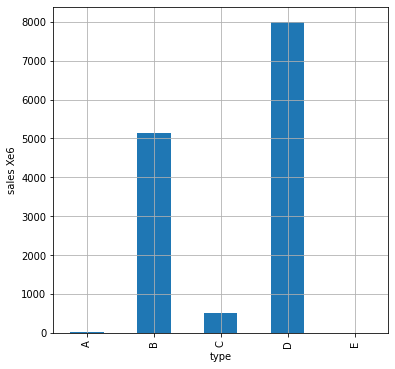

In [ ]:
fig=plt.subplots(figsize=(6,6))
t=pdf_item_1503844.groupby(['type'])['unit_sales'].sum()
ax=t.plot(kind='bar')
ax.grid()
ax.set_ylabel('sales Xe6')


In [ ]:
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month
date,,,,,,,,,,,,,,,
2016-01-02,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1
2016-01-03,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1
2016-01-04,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1
2016-01-04,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1
2016-01-05,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1


In [ ]:
pdf_item_1503844['Address']=pdf_item_1503844['city'].astype('string')+','+pdf_item_1503844['state'].astype('string')

In [ ]:
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month,Address,Lat_x,Long_x,Points,Lat_y,Long_y
0,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1,"Nagpur,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN
1,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1,"Mumbai,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN
2,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1,"Mumbai,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN
3,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1,"Nagpur,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN
4,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1,"Delhi,NCR",NaN,NaN,"(nan, nan)",NaN,NaN


# Spatial Visualizations

**Geocoding the Data based on location**

In [ ]:
geolocations=pd.read_csv('/content/drive/MyDrive/Final_Hack/geolocations.csv')

In [ ]:
pdf_item_1503844=pd.merge(pdf_item_1503844,geolocations,how='left',on='Address')


In [ ]:
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month,Address,Lat_x,Long_x,Points,Lat_y,Long_y,Lat,Long
0,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1,"Nagpur,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN,21.1458,79.0882
1,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1,"Mumbai,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN,19.0760,72.8777
2,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1,"Mumbai,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN,19.0760,72.8777
3,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1,"Nagpur,Maharashtra",NaN,NaN,"(nan, nan)",NaN,NaN,21.1458,79.0882
4,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1,"Delhi,NCR",NaN,NaN,"(nan, nan)",NaN,NaN,28.7041,77.1025


In [ ]:
pdf_item_1503844['Points']=list(zip(pdf_item_1503844['Long'],pdf_item_1503844['Lat']))

In [ ]:
pdf_item_1503844.drop(columns=['Lat_x','Lat_y','Long_x','Long_y'],inplace=True)

In [ ]:


pdf_item_1503844['Points']=pdf_item_1503844['Points'].apply(Point)

In [ ]:
gdf_item_1503844=gpd.GeoDataFrame(pdf_item_1503844,geometry='Points')

In [ ]:
gdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month,Address,Points,Lat,Long
0,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1,"Nagpur,Maharashtra",POINT (79.08820 21.14580),21.1458,79.0882
1,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1,"Mumbai,Maharashtra",POINT (72.87770 19.07600),19.0760,72.8777
2,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1,"Mumbai,Maharashtra",POINT (72.87770 19.07600),19.0760,72.8777
3,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1,"Nagpur,Maharashtra",POINT (79.08820 21.14580),21.1458,79.0882
4,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1,"Delhi,NCR",POINT (77.10250 28.70410),28.7041,77.1025


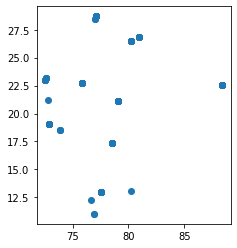

In [ ]:
gdf_item_1503844.plot()

In [ ]:
gdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month,Address,Points,Lat,Long
0,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1,"Nagpur,Maharashtra",POINT (79.08820 21.14580),21.1458,79.0882
1,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1,"Mumbai,Maharashtra",POINT (72.87770 19.07600),19.0760,72.8777
2,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1,"Mumbai,Maharashtra",POINT (72.87770 19.07600),19.0760,72.8777
3,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1,"Nagpur,Maharashtra",POINT (79.08820 21.14580),21.1458,79.0882
4,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1,"Delhi,NCR",POINT (77.10250 28.70410),28.7041,77.1025


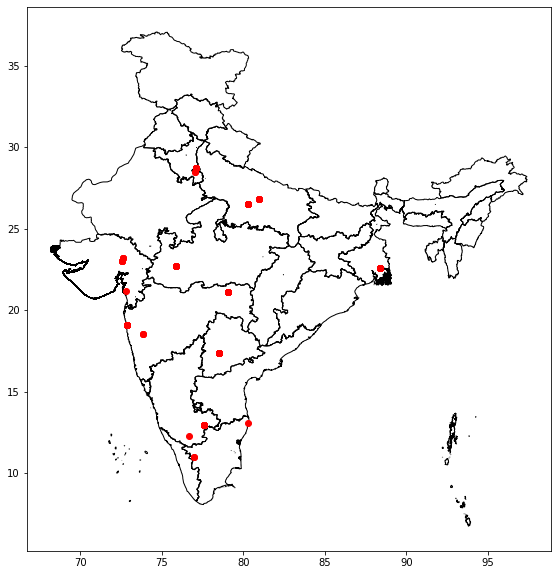

In [ ]:
states=gpd.read_file('/content/drive/MyDrive/Final_Hack/india_administrative_state_boundary/india_administrative_state_boundary.shp')
ax=states.plot(edgecolor='k',facecolor='none',figsize=(20,10))
gdf_item_1503844.plot(ax=ax,color='red')

Text(0.5, 0, 'states')

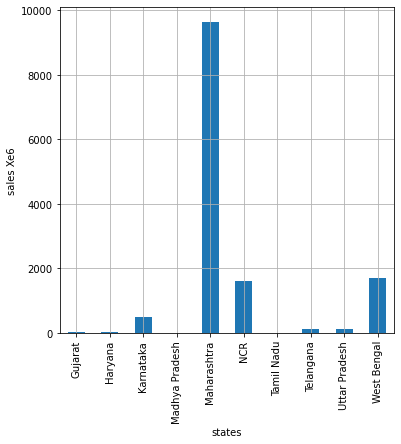

In [ ]:
cum_Sales_statewise=gdf_item_1503844.groupby('state')['unit_sales'].sum().to_frame()


fig=plt.subplots(figsize=(6,6))
t=cum_Sales_statewise.unit_sales
ax=t.plot(kind='bar')
ax.grid()
ax.set_ylabel('sales Xe6')
ax.set_xlabel('states')



**We can observe that Maharastra has highest sales figure among the states followed by NCR**

In [ ]:
cum_Sales_statewise.reset_index()
states.head()


,gid,st_nm,tid,territory_,geometry
0,1,Andaman & Nicobar Island,None,None,"MULTIPOLYGON (((93.71976 7.20707, 93.71909 7.2..."
1,2,Arunanchal Pradesh,None,None,"POLYGON ((96.16261 29.38078, 96.16860 29.37432..."
2,3,Assam,None,None,"MULTIPOLYGON (((89.74323 26.30362, 89.74290 26..."
3,4,Bihar,None,None,"MULTIPOLYGON (((84.50720 24.26323, 84.50355 24..."
4,5,Chandigarh,None,None,"POLYGON ((76.84147 30.75996, 76.83599 30.73623..."


In [ ]:
states.index

RangeIndex(start=0, stop=36, step=1)

In [ ]:
sales_state=pd.merge(states,cum_Sales_statewise,left_on='st_nm',right_on='state',how='inner')
sales_state

,gid,st_nm,tid,territory_,geometry,unit_sales
0,10,Gujarat,None,None,"MULTIPOLYGON (((71.70375 20.99958, 71.70375 20...",14.8670
1,11,Haryana,None,None,"POLYGON ((76.85065 30.87512, 76.86594 30.86691...",14.1740
2,15,Karnataka,None,None,"MULTIPOLYGON (((74.69694 13.32782, 74.69562 13...",479.5410
3,18,Madhya Pradesh,None,None,"MULTIPOLYGON (((74.17932 22.39059, 74.17776 22...",8.8460
4,19,Maharashtra,None,None,"MULTIPOLYGON (((73.46270 16.03710, 73.46178 16...",9628.8933
5,29,Tamil Nadu,None,None,"MULTIPOLYGON (((78.19188 8.72730, 78.18996 8.7...",3.1530
6,30,Telangana,None,None,"POLYGON ((81.05614 17.79097, 81.05834 17.75464...",108.6310
7,32,Uttar Pradesh,None,None,"MULTIPOLYGON (((80.44802 24.99631, 80.44080 24...",111.3424
8,34,West Bengal,None,None,"MULTIPOLYGON (((88.01861 21.57278, 88.01889 21...",1703.1970


In [ ]:
!pip install mapclassify

***`We can observe the states which comes under high sales bands and low sales bands `***

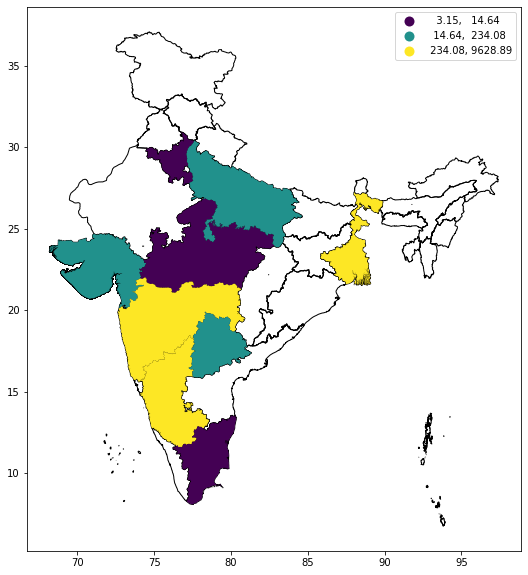

In [ ]:
import mapclassify as mc
import matplotlib.pyplot as plt

ax=states.plot(edgecolor='k',facecolor='none',figsize=(20,10))
sales_state.plot(column='unit_sales',scheme='Quantiles',ax=ax,legend=True,k=3)

## **We can observe 3 levels of sales for this item**


1.   High sales states
2.   Medium sales states
3.   Low sales states



# Model Building (Time series)

In [ ]:
!pip install statsmodels

In [8]:
pdf_item_1503844.head()

,locationId,item_id,_c0,unit_sales,onpromotion,city,state,type,cluster,category_of_item,class,perishable,transactions,year,month
date,,,,,,,,,,,,,,,
2016-01-02,location_31,item_1503844,16361843,10.892,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1471.0,2016,1
2016-01-03,location_26,item_1503844,16422851,5.985,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,725.0,2016,1
2016-01-04,location_26,item_1503844,16489599,6.923,None,Mumbai,Maharashtra,D,10,other_farm_produce,class_2022,1,810.0,2016,1
2016-01-04,location_31,item_1503844,16494960,4.185,None,Nagpur,Maharashtra,B,10,other_farm_produce,class_2022,1,1573.0,2016,1
2016-01-05,location_5,item_1503844,16533615,14.000,None,Delhi,NCR,D,4,other_farm_produce,class_2022,1,1669.0,2016,1


In [9]:
pdf_item_1047679.reset_index(inplace=True)
ts_item_1047679=pdf_item_1047679.groupby('date')['unit_sales'].sum().to_frame()

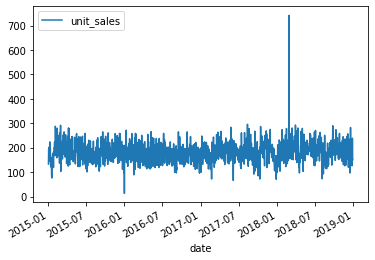

In [10]:
ts_item_1047679.plot()

**Weekly predictions**

In [29]:
t = ts_item_1047679['unit_sales'].resample('w').sum()
t=t.to_frame()

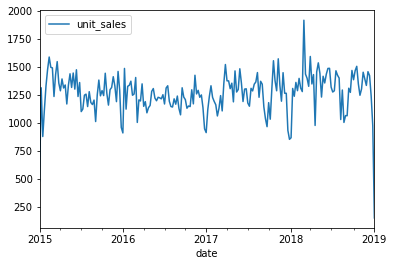

In [30]:
t.plot()

In [31]:
from statsmodels.tsa.stattools import adfuller

In [32]:
adfuller(t['unit_sales'])

(-8.91765614575976,
 1.0619191675120198e-14,
 0,
 209,
 {'1%': -3.4620315036789666,
  '10%': -2.5741950726860647,
  '5%': -2.8754705024827127},
 2517.6173209332796)

In [33]:

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [34]:
adfuller_test(t['unit_sales'])

ADF Test Statistic : -8.91765614575976
p-value : 1.0619191675120198e-14
#Lags Used : 0
Number of Observations Used : 209
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


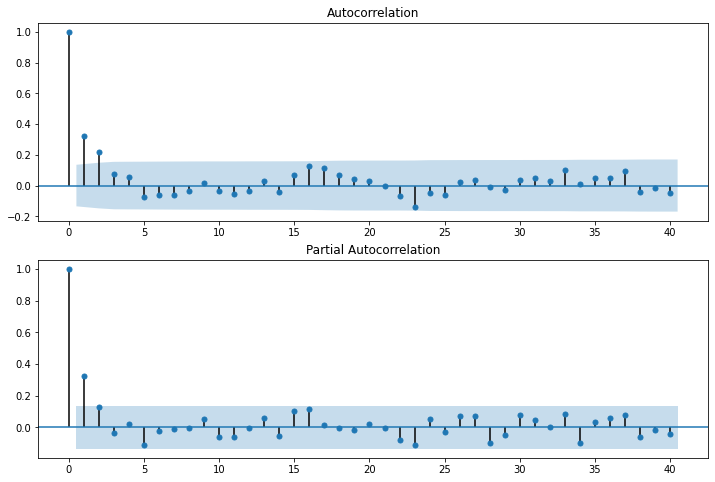

In [35]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(t['unit_sales'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(t['unit_sales'],lags=40,ax=ax2)

In [54]:
model=sm.tsa.statespace.SARIMAX(t['unit_sales'],order=(3, 3, 1),seasonal_order=(3,3,1,7))
results=model.fit()

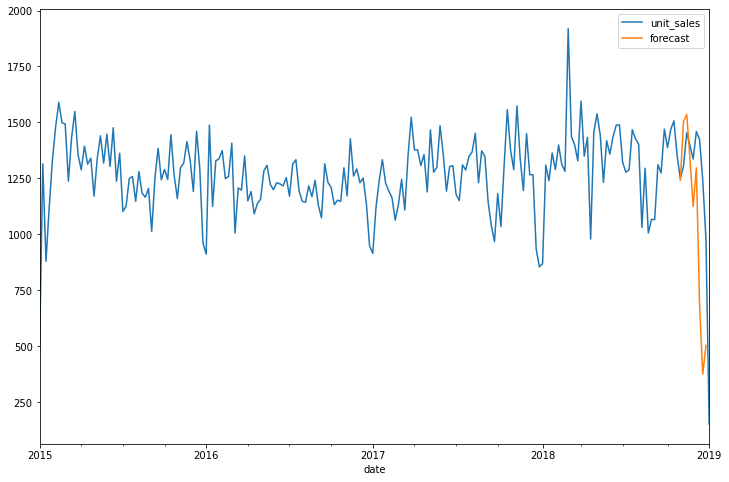

In [49]:

t['forecast']=results.predict(start=200,end=208,dynamic=True)
t[['unit_sales','forecast']].plot(figsize=(12,8))

Daily predictions

In [51]:
model=sm.tsa.statespace.SARIMAX(ts_item_1047679['unit_sales'],order=(3, 3, 1),seasonal_order=(3,3,1,365))
results=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ValueError: ignored